In [1]:
import torch
from Nets import NetTaskIL
from functions import test
from dataloaders.mnist import MNIST_for_classes_TaskIL, MNIST
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

torch.cuda.is_available()
device = 'cuda'

In [2]:
import torch.nn.functional as F

def train_validation_all_classes(model, optimizer, tasks, epoch=1, log_interval = 1000):
    train_losses = []
    tasks_losses = [[], [], [], [], []]
    exemplers = []
    model.train()
    for taskNo in range(len(tasks)):
        for batch_idx, (data, target) in enumerate(tasks[taskNo]):
            exemplers.append(tasks[taskNo].batch_size * batch_idx)
            optimizer.zero_grad()
            output = model(taskNo, data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print(f"Train [{batch_idx * len(data)} / {len(tasks[taskNo].dataset)}]       loss: {loss.item()}")
                for i in range(len(tasks)):
                    tasks_losses[i].append(test(model, tasks[i], i, print_accuracy=False))

            train_losses.append(loss.item())
    return train_losses, tasks_losses, exemplers

def test(model, test_loader, taskNo, print_accuracy=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(taskNo, data)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    if print_accuracy:
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [3]:
task1 = MNIST_for_classes_TaskIL(0, 1)
task2 = MNIST_for_classes_TaskIL(2, 3)
task3 = MNIST_for_classes_TaskIL(4, 5)
task4 = MNIST_for_classes_TaskIL(6, 7)
task5 = MNIST_for_classes_TaskIL(8, 9)

tasks = [task1 ,task2, task3, task4, task5]

_, _, test_loader = MNIST()

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


-------------------------------------------------- benchmark normal training --------------------------------------------------
Train [0 / 12665]       loss: 0.6862922310829163


c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train [1280 / 12665]       loss: 0.10342900454998016
Train [2560 / 12665]       loss: 0.011702434159815311
Train [3840 / 12665]       loss: 0.014245218597352505
Train [5120 / 12665]       loss: 0.006264213938266039
Train [6400 / 12665]       loss: 0.00949816219508648
Train [7680 / 12665]       loss: 0.012506849132478237
Train [8960 / 12665]       loss: 0.0053229788318276405
Train [10240 / 12665]       loss: 0.0014321054331958294
Train [11520 / 12665]       loss: 0.030196772888302803
Train [0 / 12089]       loss: 0.7633536458015442
Train [1280 / 12089]       loss: 0.5389575958251953
Train [2560 / 12089]       loss: 0.21274463832378387
Train [3840 / 12089]       loss: 0.09238742291927338
Train [5120 / 12089]       loss: 0.09138757735490799
Train [6400 / 12089]       loss: 0.04608732834458351
Train [7680 / 12089]       loss: 0.046196989715099335
Train [8960 / 12089]       loss: 0.044946156442165375
Train [10240 / 12089]       loss: 0.04882412776350975
Train [11520 / 12089]       loss: 0.0

TypeError: test() missing 1 required positional argument: 'taskNo'

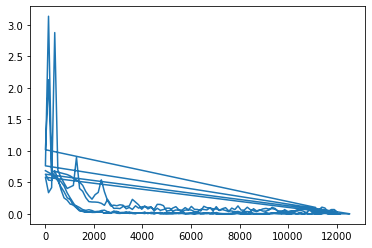

In [7]:
print('-'*50, 'benchmark normal training', '-'*50)
model = NetTaskIL(10)
optimizer = optim.SGD(model.parameters(), lr=0.1)


train_losses, tasks_losses, exemplers = train_validation_all_classes(model, optimizer, tasks, epoch=1, log_interval = 10)

plt.plot(exemplers, train_losses)
# test(model, test_loader)

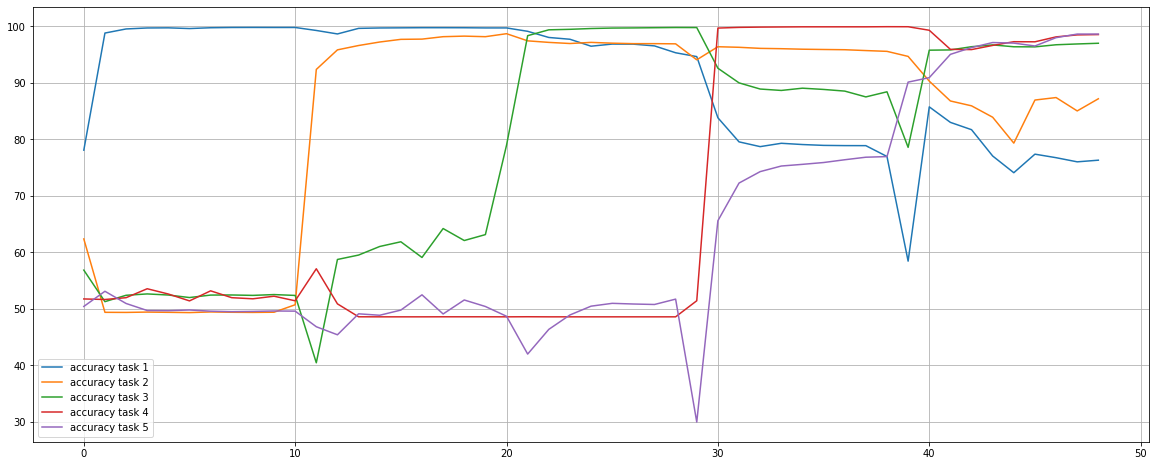

In [8]:
plt.figure(figsize=(20,8))
for i in range(len(tasks_losses)):
    plt.plot(tasks_losses[i])

plt.legend([f"accuracy task {i+1}" for i in range(len(tasks_losses))])
plt.grid()
plt.show()

In [9]:
tasks_acc = tasks_losses

In [11]:
# import pickle

# with open('taskILMNIST.pkl', 'wb') as f:
#     pickle.dump([tasks_acc, train_losses], f)